<a href="https://colab.research.google.com/github/nebirsad/qsar-cadd/blob/main/Drug_Designing_Project_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Retrieval From ChEMBL Database**
My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TechOpenCADD project of Volkamer Lab. With some minor modifications, I tried to made it available for the students working with a Biology background. For Proper understanding and learning, you can follow the video tutorial on **Bioinformatics Insights** https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

This notebook is majorly designed for teaching purposes.

For citation and reading, https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x


**Learning and Training Objectives**
1. Retrieving compound data and activities from ChEMBL for a protein (receptor) of your choice.
**Understanding units**

**1. IC50** is a standared unit used in biochemical assays for inhibition. It stands for Inhibitory concentration at 50 or Half maximal inhibitory concentration. The lower value indicates higher potency of a drug. You may also see **pIC50**, that is = -log10(IC50). It makes the opposite of IC50, meaning higher pIC50 means higher potency of a drug.

Let's begin,


##Pre-requisite Installation and Imports

In [3]:
! pip install chembl_webresource_client
! pip install rdkit-pypi
!pip install --upgrade rdkit-pypi

In [4]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [5]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Creating some API tokens for target

In [6]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [7]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In this tutorial we will use **Epidermal Growth Factor (EGFR)** protein, which is a kinase by nature. We will fetch them from Uniprot Accession ID.

In [8]:
uniprot_id = "C7C422"

In [9]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [10]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Klebsiella pneumoniae,Beta-lactamase NDM-1,CHEMBL1667695,SINGLE PROTEIN
1,Klebsiella pneumoniae,Beta-lactamase NDM-1,CHEMBL1667695,SINGLE PROTEIN
2,Bacteria,Beta-lactamase NDM-1,CHEMBL5465386,SINGLE PROTEIN


Below we will select the exact ChEMBL data via index options

In [11]:
target = targets.iloc[0]
target

,0
organism,Klebsiella pneumoniae
pref_name,Beta-lactamase NDM-1
target_chembl_id,CHEMBL1667695
target_type,SINGLE PROTEIN


In [12]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL1667695


Below we are going to fetch some important variable of the data for ourself. You can change them if you want to extract some other column.

In [13]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 32, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [14]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 16533835,
 'assay_chembl_id': 'CHEMBL3789280',
 'assay_description': 'Inhibition of His-tagged Klebsiella pneumoniae NDM-1 expressed in Escherichia coli BL21-AI cells using imipinem as substrate',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL1379384',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '3109000.0',
 'target_chembl_id': 'CHEMBL1667695',
 'target_organism': 'Klebsiella pneumoniae',
 'type': 'IC50',
 'units': 'uM',
 'value': '3109.0'}

Download the dataset

In [15]:
#Downloading Data
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (32, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,16533835,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1379384,=,nM,3109000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50,uM,3109.0
1,16533836,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1327484,=,nM,1238000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50,uM,1238.0
2,16533837,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL582878,=,nM,1946000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50,uM,1946.0
3,16533838,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL3278535,=,nM,480000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50,uM,480.0
4,16533845,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1560,=,nM,49800.0,CHEMBL1667695,Klebsiella pneumoniae,IC50,uM,49.8


It is possible that some of the rows show redundant data, but do not worry we will remove that later

**Now we want to know how many different units are present in the data**

In [16]:
bioactivities_df["units"].unique()

array(['uM', 'nM'], dtype=object)

Below we will do some tweaking with units to make them uniform

In [17]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,16533835,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1379384,=,nM,3109000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
1,16533836,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1327484,=,nM,1238000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
2,16533837,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL582878,=,nM,1946000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
3,16533838,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL3278535,=,nM,480000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
4,16533845,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1560,=,nM,49800.0,CHEMBL1667695,Klebsiella pneumoniae,IC50


**Data Processing and Filteration**

Delete entries with missing and duplicate values.

Reset index number and rename columns.



In [18]:
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,object
target_chembl_id,object
target_organism,object


In [19]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,float64
target_chembl_id,object
target_organism,object


In [20]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (32, 11)


In [21]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [22]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [23]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (32, 11)


In [24]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (32, 11)


In [25]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,16533835,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1379384,=,nM,3109000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
1,16533836,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1327484,=,nM,1238000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
2,16533837,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL582878,=,nM,1946000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
3,16533838,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL3278535,=,nM,480000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
4,16533845,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1560,=,nM,49800.0,CHEMBL1667695,Klebsiella pneumoniae,IC50


In [26]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,16533835,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1379384,=,nM,3109000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
1,16533836,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1327484,=,nM,1238000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
2,16533837,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL582878,=,nM,1946000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
3,16533838,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL3278535,=,nM,480000.0,CHEMBL1667695,Klebsiella pneumoniae,IC50
4,16533845,CHEMBL3789280,Inhibition of His-tagged Klebsiella pneumoniae...,B,CHEMBL1560,=,nM,49800.0,CHEMBL1667695,Klebsiella pneumoniae,IC50


In [27]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (32, 11)


**Fetch compound data from ChEMBL**

Let’s have a look at the compounds from ChEMBL which we have defined so far. bioactivity data for: We are going to fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [28]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

**Download Compounds**

In [29]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (32, 2)


In [31]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL1560,{'canonical_smiles': 'C[C@H](CS)C(=O)N1CCC[C@H...
1,CHEMBL582878,{'canonical_smiles': 'O=C(O)CCCc1c[nH]c2ccccc1...
2,CHEMBL1327484,{'canonical_smiles': 'O=C(O)CSc1ccnc2cc(Cl)ccc...
3,CHEMBL1379384,{'canonical_smiles': 'CCCc1ccc(C(=O)CCC(=O)O)c...
4,CHEMBL2203744,{'canonical_smiles': 'CN(C(=S)NN=C(c1ccccn1)c1...


In [32]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (32, 2)


In [33]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (32, 2)


In [34]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [35]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (32, 2)


In [36]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (32, 2)


**Let's output compound bioactivity data**

In [37]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 32


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [38]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 32


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**Lets merge both the datasets**

Merge to contain, molecule ID, IC50, Units, and canonical smiles

In [39]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 32 entries.


In [40]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [41]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL1379384,3109000.0,nM,CCCc1ccc(C(=O)CCC(=O)O)cc1
1,CHEMBL1327484,1238000.0,nM,O=C(O)CSc1ccnc2cc(Cl)ccc12
2,CHEMBL582878,1946000.0,nM,O=C(O)CCCc1c[nH]c2ccccc12
3,CHEMBL3278535,480000.0,nM,N#Cc1coc2ccccc2c1=O
4,CHEMBL1560,49800.0,nM,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
5,CHEMBL3809576,160.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1cccc(Cl)c1
6,CHEMBL3810416,1200.0,nM,O=C(CSc1nnc(-c2ccc(O)cc2)[nH]1)Nc1ccccc1
7,CHEMBL3809666,980.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1ccccc1Cl
8,CHEMBL3808671,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3O)[nH]2)cc1
9,CHEMBL3809559,930.0,nM,CCc1ccccc1NC(=O)CSc1nnc(-c2ccccc2O)[nH]1


**Convert IC50 values into pIC50 and put it in an extra column**

In [42]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [43]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [44]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL1379384,3109000.0,nM,CCCc1ccc(C(=O)CCC(=O)O)cc1,2.507379
1,CHEMBL1327484,1238000.0,nM,O=C(O)CSc1ccnc2cc(Cl)ccc12,2.907279
2,CHEMBL582878,1946000.0,nM,O=C(O)CCCc1c[nH]c2ccccc12,2.710857
3,CHEMBL3278535,480000.0,nM,N#Cc1coc2ccccc2c1=O,3.318759
4,CHEMBL1560,49800.0,nM,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O,4.302771


**Distribution Based on IpIC50**

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

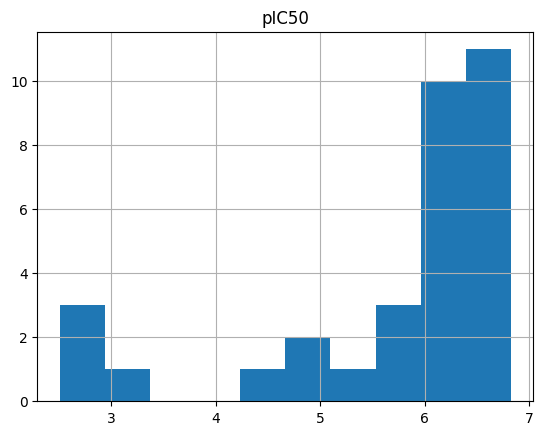

In [45]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [46]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

Failed to patch pandas - unable to change molecule rendering


In [47]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [48]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL3810052,150.0,nM,6.823909,<rdkit.Chem.rdchem.Mol object at 0x7c4ae27ee030>
1,CHEMBL3809576,160.0,nM,6.795880,<rdkit.Chem.rdchem.Mol object at 0x7c4ae27edc40>
2,CHEMBL3808671,160.0,nM,6.795880,<rdkit.Chem.rdchem.Mol object at 0x7c4ae27edd90>


In [49]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (32, 5)


**Save Dataset for Next Session**

In [50]:
output_df.to_csv("/content/nmd_dataset1.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL3810052,150.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3)[nH]2)cc1,6.823909
1,CHEMBL3809576,160.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1cccc(Cl)c1,6.795880
2,CHEMBL3808671,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3O)[nH]2)cc1,6.795880
3,CHEMBL3809719,160.0,nM,Cc1ccccc1NC(=O)CSc1nnc(-c2ccccc2O)[nH]1,6.795880
4,CHEMBL3809806,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3N)[nH]2)cc1,6.795880


In [51]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (32, 5)


##**Congratulation! You have started learning something new**

If you happy for your time, Please provide your Support in the Form of a Subscription on Youtube Channel**

[**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

Follow [**WhatsApp Channel**](https://whatsapp.com/channel/0029VajkwkdCHDydS6Y2lM36) for further updates, research services, and courses.